In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from operator import itemgetter

In [2]:
with open('./data/autori_cleaned', 'rb') as file:
    autori = pd.read_pickle(file)
with open('./data/data_cleaned', 'rb') as file:
    data = pd.read_pickle(file)

In [3]:
print(autori.head())
print(data.head())

          Ime            Prezime                    Katedra  H indeks  \
0       tanja          jovanovic  katedra za mikrobiologiju        11   
1  branislava              savic  katedra za mikrobiologiju        10   
2       sanja           mitrovic  katedra za mikrobiologiju         4   
3       lazar              ranin  katedra za mikrobiologiju         7   
4   valentina  arsic-arsenijevic  katedra za mikrobiologiju        17   

   Broj radova  id                     Puno ime              Skraceno  
0           45   0              tanja jovanovic          jovanovic t.  
1           30   1             branislava savic              savic b.  
2           20   2               sanja mitrovic           mitrovic s.  
3           40   3                  lazar ranin              ranin l.  
4           52   4  valentina arsic-arsenijevic  arsic-arsenijevic v.  
                    Author                                              Title  \
0  jasmina simonovic-babic  state of viral hepat

In [7]:
G = nx.Graph()
for _,row in autori.iterrows():
    G.add_node(row['Puno ime'], katedra=row['Katedra'])
KatedreGraph = nx.Graph()
for _,row in autori.iterrows():
    KatedreGraph.add_node(row['Puno ime'], katedra=row['Katedra'])

In [9]:
from itertools import combinations

title_grouped = data.groupby('Title')['Author']
for _,authors in title_grouped:
    author_list = authors.tolist()
    author_pairs = combinations(author_list,2)
    for autor1,autor2 in author_pairs:
        if (autor1, autor2) in G.edges:
            G.edges[autor1,autor2]['weight'] += 1
        else:
            G.add_edge(autor1, autor2, weight=1)

katedra_grouped = data.groupby('Katedra')['Author']
for _,authors in katedra_grouped:
    author_list = authors.tolist()
    author_pairs = combinations(author_list,2)
    for autor1,autor2 in author_pairs:
           KatedreGraph.add_edge(autor1, autor2)


In [13]:
output_path="models/undirected_papper_colaboration.gml"
nx.write_gml(G, output_path)

output_path="models/undirected_katedra.gml"
nx.write_gml(KatedreGraph, output_path)

In [9]:
# Calculate density
density = nx.density(G)
print(f'Network Density: {density}')

Network Density: 0.1748911465892598


In [10]:
avg_distance = nx.average_shortest_path_length(G)
print(f'Average Distance: {avg_distance}')

Average Distance: 2.3570391872278664


In [11]:
diameter = nx.diameter(G)
print(f'Diameter: {diameter}')

Diameter: 5


In [12]:
if nx.is_connected(G):
    num_components = 1
    component_sizes = [len(G.nodes)]
else:
    components = list(nx.connected_components(G))
    num_components = len(components)
    component_sizes = [len(component) for component in components]

print(f'Number of Connected Components: {num_components}')
print(f'Size of Each Component: {component_sizes}')

Number of Connected Components: 1
Size of Each Component: [53]


Imam jednu dzinovsku komponentu?

In [14]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df

In [15]:
df = calculate_centralities(G)
print(df.head(5))
print(f'Centralnost sortirana po DC: \n {df.sort_values(['DC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po CC:  \n {df.sort_values(['CC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po BC: \n {df.sort_values(['BC'], ascending=False).head(5)}')
print(f'Centralnost sortirana po EVC: \n {df.sort_values(['EVC'], ascending=False).head(5)}')

                                   DC        CC        BC       EVC
tanja jovanovic              0.192308  0.504854  0.028419  0.141412
branislava savic             0.134615  0.400000  0.007689  0.053655
sanja mitrovic               0.153846  0.452174  0.057838  0.044523
lazar ranin                  0.230769  0.440678  0.058853  0.100766
valentina arsic-arsenijevic  0.134615  0.444444  0.032813  0.044053
Centralnost sortirana po DC: 
                         DC        CC        BC       EVC
ivana lazarevic   0.365385  0.553191  0.171774  0.303525
goran stevanovic  0.288462  0.509804  0.066559  0.265913
maja cupic        0.288462  0.514851  0.065122  0.184637
vera mijac        0.269231  0.500000  0.073322  0.120571
milos korac       0.269231  0.485981  0.046700  0.265604
Centralnost sortirana po CC:  
                            DC        CC        BC       EVC
ivana lazarevic      0.365385  0.553191  0.171774  0.303525
aleksandra knezevic  0.192308  0.514851  0.030857  0.137538
maja cu

In [16]:
def centralizationGraph(G):
    centralities = nx.degree_centrality(G)
    star_centralities = nx.degree_centrality(nx.star_graph(len(G.nodes)))
    max_centrality = max(centralities.values())
    max_centrality_star = max(star_centralities.values())
    centralization = sum(max_centrality - c for c in centralities.values()) / sum(max_centrality_star - c for c in star_centralities.values())
    return centralization
centralization_value = centralizationGraph(G)
print(f'Centralization: {centralization_value:.4f}')


Centralization: 0.1942


In [17]:
global_clustering_coefficient = nx.transitivity(G)
print(f'Global Clustering Coefficient (Transitivity): {global_clustering_coefficient}')

average_clustering_coefficient = nx.average_clustering(G)
print(f'Average Clustering Coefficient: {average_clustering_coefficient}')

local_clustering_coefficients = nx.clustering(G).values()


Global Clustering Coefficient (Transitivity): 0.5450928381962865
Average Clustering Coefficient: 0.6005288212835382


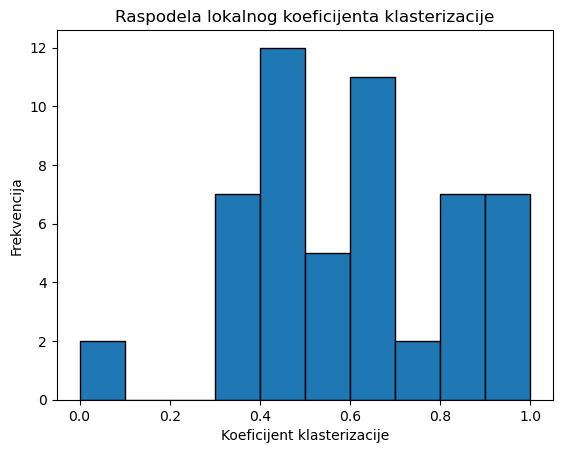

In [18]:
# 2. Plot the distribution of local clustering coefficients
plt.hist(local_clustering_coefficients, bins=10, edgecolor='black')
plt.title('Raspodela lokalnog koeficijenta klasterizacije')
plt.xlabel('Koeficijent klasterizacije')
plt.ylabel('Frekvencija')
plt.savefig('koeficijent_klasterizacije.png')
plt.show()

In [19]:
# Erdos-Renyi Random Graph
n = G.number_of_nodes()
p = nx.density(G)  
G_erdos = nx.erdos_renyi_graph(n, p)

In [20]:
# Scale-Free Network
G_scale_free_multi = nx.scale_free_graph(n,alpha=0.12, beta=0.80, gamma = 0.08)
G_scale_free = nx.Graph(G_scale_free_multi)

In [21]:
# Calculate clustering coefficients for comparison
average_clustering_erdos = nx.average_clustering(G_erdos)
average_clustering_scale_free = nx.average_clustering(G_scale_free)
transitivity_erdos = nx.transitivity(G_erdos)
transitivity_scale_free = nx.transitivity(G_scale_free)

print(f'Erdos-Renyi Average Clustering Coefficient: {average_clustering_erdos}')
print(f'Erdos-Renyi Global Clustering Coefficient: {transitivity_erdos}')
print(f'Scale-Free Average Clustering Coefficient: {average_clustering_scale_free}')
print(f'Scale-Free Global Clustering Coefficient: {transitivity_scale_free}')

Erdos-Renyi Average Clustering Coefficient: 0.15774142000557095
Erdos-Renyi Global Clustering Coefficient: 0.16109422492401215
Scale-Free Average Clustering Coefficient: 0.21772441756176306
Scale-Free Global Clustering Coefficient: 0.11816192560175055


In [22]:
print(len(G_scale_free.edges))

83


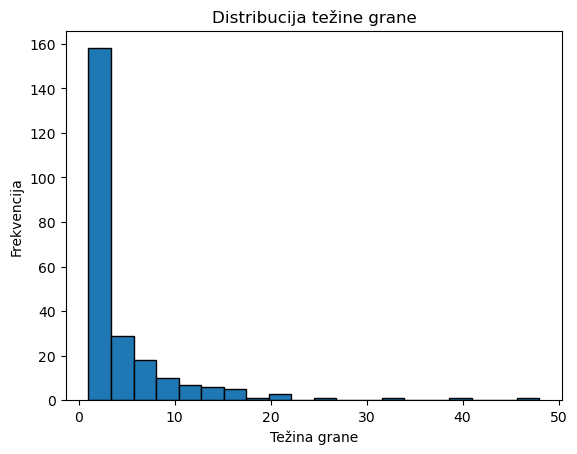

In [23]:
# 1. Edge Weight Distribution
weights = [data['weight'] for u, v, data in G.edges(data=True)]
plt.hist(weights, bins=20, edgecolor='black')
plt.title('Distribucija težine grane')
plt.xlabel('Težina grane')
plt.ylabel('Frekvencija')
plt.savefig('distribucija-tezine-grane.png')
plt.show()


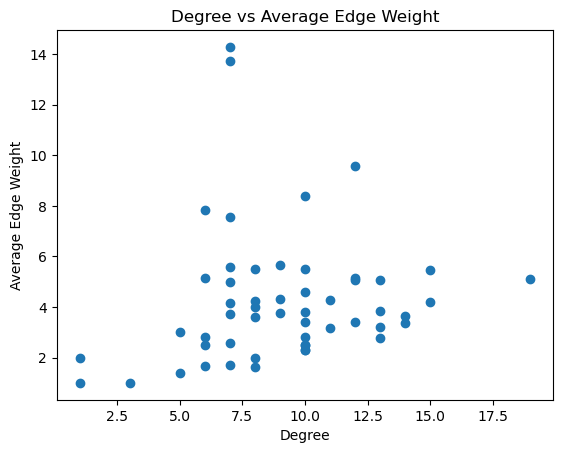

In [24]:
# 2. Degree vs. Average Edge Weight  vidi sto ti ovo po stepenu???
degrees = dict(G.degree())
strengths = dict(G.degree(weight='weight'))
avg_edge_weights = {node: strengths[node] / degrees[node] for node in G.nodes()}
plt.scatter(degrees.values(), avg_edge_weights.values())
plt.title('Degree vs Average Edge Weight')
plt.xlabel('Degree')
plt.ylabel('Average Edge Weight')
plt.show()


In [25]:
assortativity_coefficient = nx.degree_assortativity_coefficient(G)
print(f'Degree Assortativity Coefficient: {assortativity_coefficient}')

Degree Assortativity Coefficient: 0.04567166142802434


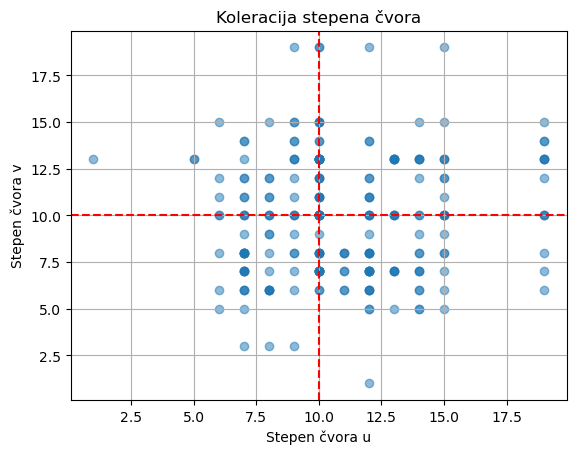

In [26]:
degrees = dict(G.degree())
x, y = zip(*[(degrees[u], degrees[v]) for u, v in G.edges()])

plt.scatter(x, y, alpha=0.5)
plt.axvline(x=10, color='red', linestyle='--')
plt.axhline(y=10, color='red', linestyle='--')
plt.title('Koleracija stepena čvora')
plt.xlabel('Stepen čvora u')
plt.ylabel('Stepen čvora v')
plt.grid(True)
plt.savefig('koleracija-stepena-cvora.png')
plt.show()

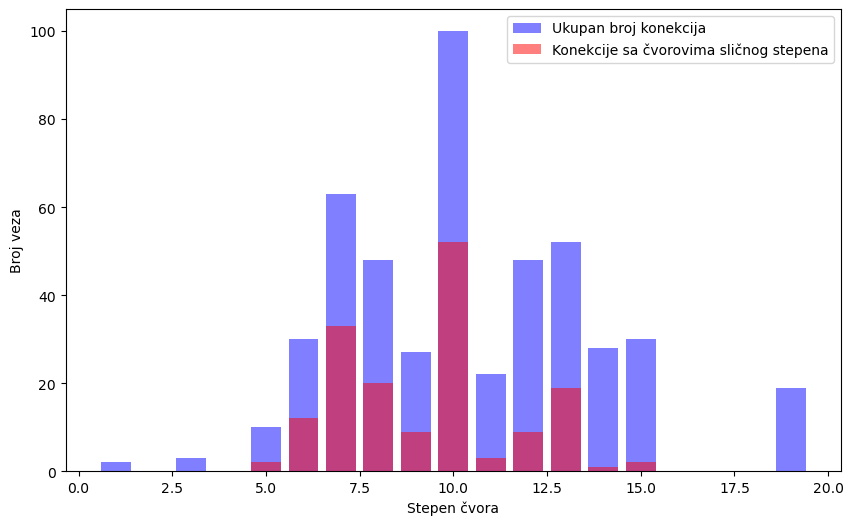

In [27]:
from collections import defaultdict

edges_per_degree = defaultdict(int)
higher_or_equal_edges_per_degree = defaultdict(int)

for u, v in G.edges():
    degree_u = degrees[u]
    degree_v = degrees[v]
    
    edges_per_degree[degree_u] += 1
    edges_per_degree[degree_v] += 1
    
    if degree_v >= degree_u and degree_v - 3 <= degree_u:
        higher_or_equal_edges_per_degree[degree_u] += 1
    if degree_u >= degree_v and degree_u - 3 <= degree_v:
        higher_or_equal_edges_per_degree[degree_v] += 1

sorted_degrees = sorted(edges_per_degree.keys())
total_edges = [edges_per_degree[d] for d in sorted_degrees]
higher_or_equal_edges = [higher_or_equal_edges_per_degree[d] for d in sorted_degrees]

plt.figure(figsize=(10, 6))
plt.bar(sorted_degrees, total_edges, alpha=0.5, label='Ukupan broj konekcija', color='blue')
plt.bar(sorted_degrees, higher_or_equal_edges, alpha=0.5, label='Konekcije sa čvorovima sličnog stepena', color='red')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj veza')
plt.legend()
plt.savefig('asortivnost-po-cvoru.png')

plt.show()

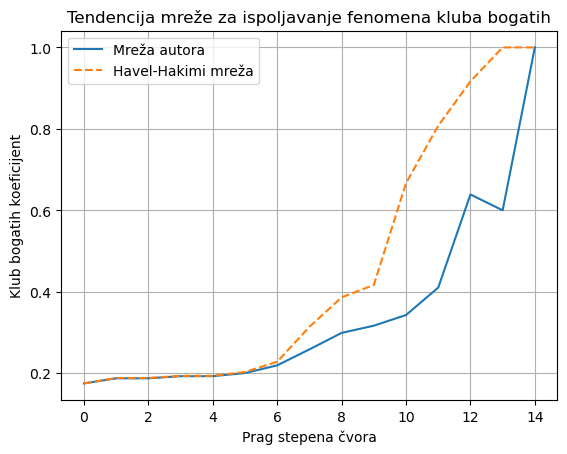

In [28]:
rich_club_coefficient_original = nx.rich_club_coefficient(G, normalized=False)

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
G_havel_hakimi = nx.havel_hakimi_graph(degree_sequence)
rich_club_coefficient_havel_hakimi = nx.rich_club_coefficient(G_havel_hakimi, normalized=False)


degrees = sorted(set(rich_club_coefficient_original.keys()) & set(rich_club_coefficient_havel_hakimi.keys()))

original_values = [rich_club_coefficient_original[d] for d in degrees]
havel_hakimi_values = [rich_club_coefficient_havel_hakimi[d] for d in degrees]

plt.plot(degrees, original_values, label='Mreža autora')
plt.plot(degrees, havel_hakimi_values, label='Havel-Hakimi mreža', linestyle='--')
plt.xlabel('Prag stepena čvora')
plt.ylabel('Klub bogatih koeficijent')
plt.title('Tendencija mreže za ispoljavanje fenomena kluba bogatih')
plt.legend()
plt.grid(True)
plt.savefig('rich-club-plot.png')
plt.show()


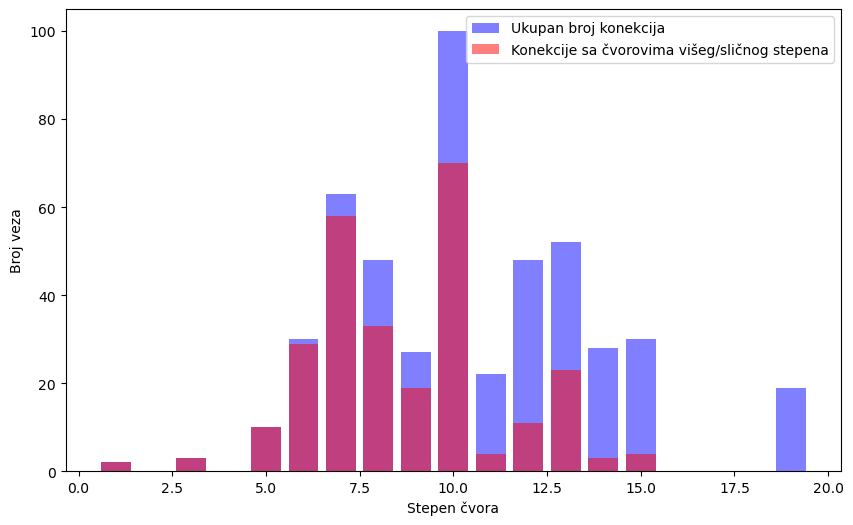

In [29]:
degrees = dict(G.degree())

edges_per_degree = defaultdict(int)
higher_or_equal_edges_per_degree = defaultdict(int)

for u, v in G.edges():
    degree_u = degrees[u]
    degree_v = degrees[v]
    
    edges_per_degree[degree_u] += 1
    edges_per_degree[degree_v] += 1
    
    if degree_v >= degree_u:
        higher_or_equal_edges_per_degree[degree_u] += 1
    if degree_u >= degree_v:
        higher_or_equal_edges_per_degree[degree_v] += 1

sorted_degrees = sorted(edges_per_degree.keys())
total_edges = [edges_per_degree[d] for d in sorted_degrees]
higher_or_equal_edges = [higher_or_equal_edges_per_degree[d] for d in sorted_degrees]

plt.figure(figsize=(10, 6))
plt.bar(sorted_degrees, total_edges, alpha=0.5, label='Ukupan broj konekcija', color='blue')
plt.bar(sorted_degrees, higher_or_equal_edges, alpha=0.5, label='Konekcije sa čvorovima višeg/sličnog stepena', color='red')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj veza')
plt.legend()
plt.savefig('ruch-club-bar-plot.png')

plt.show()

In [30]:
# 1. Calculate degree sequence
degree_sequence = [d for n, d in G.degree()]
degree_count = np.bincount(degree_sequence)
degrees = np.arange(len(degree_count))
print('degrees: ', degrees)
print('degree_count: ', degree_count)


degrees:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
degree_count:  [ 0  2  0  1  0  2  5  9  6  3 10  2  4  4  2  2  0  0  0  1]


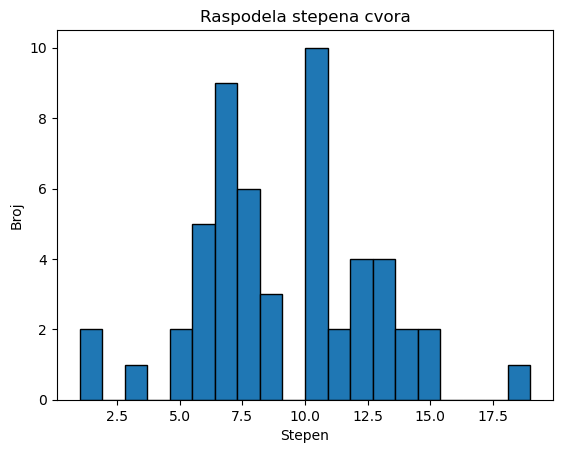

In [31]:
plt.hist(degree_sequence, bins=20, edgecolor='black')
plt.title('Raspodela stepena cvora')
plt.xlabel('Stepen')
plt.ylabel('Broj')
plt.show()


In [32]:
import powerlaw

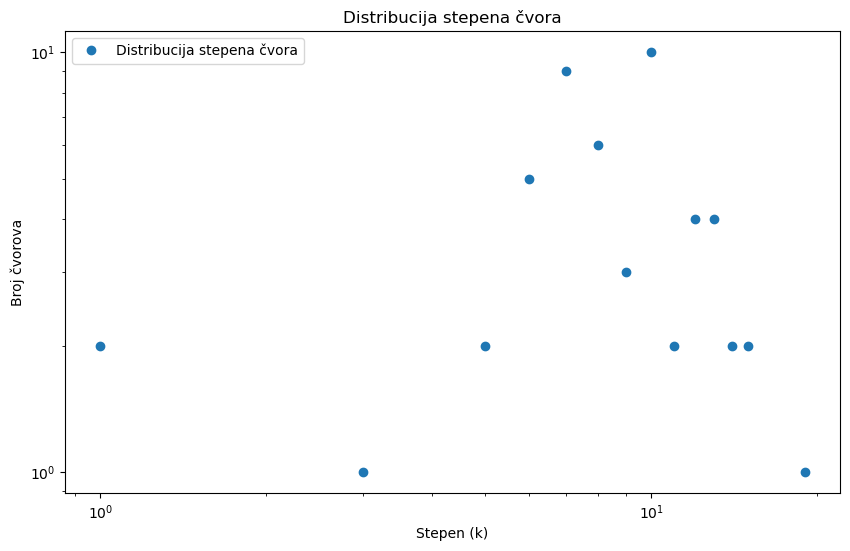

In [68]:
plt.figure(figsize=(10, 6))
plt.loglog(degrees, degree_count, marker='o', linestyle='None', label='Distribucija stepena čvora')
plt.title("Distribucija stepena čvora")
plt.xlabel("Stepen (k)")
plt.ylabel("Broj čvorova")
plt.legend()
plt.savefig('distribucija_stepena_cvora.png')
plt.show()

C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:4: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)


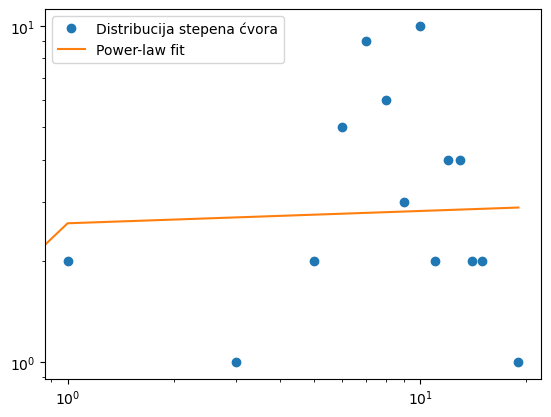

In [66]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a * np.power(x, b)

def exponential(x, a, b):
    return a * np.exp(b * x)

def log_normal(x, a, mu, sigma):
    return a / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))

def trig_function(x, a, b, c):
    return a * np.sin(b * np.log(x)) + c

# Perform curve fitting
params, _ = curve_fit(power_law, degrees, degree_count)
# You can fit other functions similarly

# Plot the data and the fit
plt.loglog(degrees, degree_count, 'o', label='Distribucija stepena ćvora')
plt.loglog(degrees, power_law(degrees, *params), label='Power-law fit')
plt.legend()
plt.show()

C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:4: RuntimeWarning: divide by zero encountered in power
  return a * np.power(x, b)


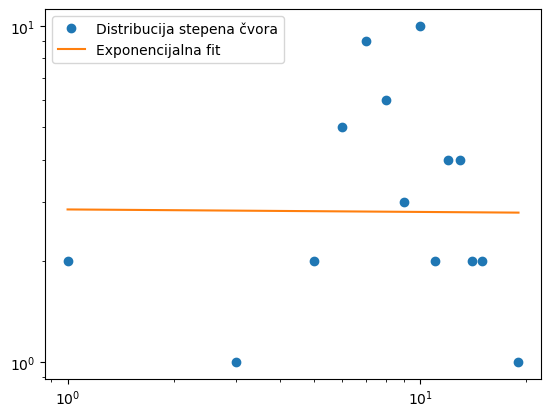

In [70]:
# Perform curve fitting
params, _ = curve_fit(exponential, degrees, degree_count)
# You can fit other functions similarly

# Plot the data and the fit
plt.loglog(degrees, degree_count, 'o', label='Distribucija stepena čvora')
plt.loglog(degrees, power_law(degrees, *params), label='Exponencijalna fit')
plt.legend()
plt.show()

In [76]:
# Perform curve fitting
params, _ = curve_fit(log_normal, degrees, degree_count, maxfev=10000)
# You can fit other functions similarly

# Plot the data and the fit
plt.loglog(degrees, degree_count, 'o', label='Distribucija stepena čvora')
plt.loglog(degrees, power_law(degrees, *params), label='Log-normalna fit')
plt.legend()
plt.show()

C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:10: RuntimeWarning: divide by zero encountered in divide
  return a / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))
C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:10: RuntimeWarning: divide by zero encountered in log
  return a / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))
C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:10: RuntimeWarning: invalid value encountered in multiply
  return a / (x * sigma * np.sqrt(2 * np.pi)) * np.exp(- (np.log(x) - mu)**2 / (2 * sigma**2))


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

In [90]:
# Perform curve fitting
params, _ = curve_fit(trig_function, degrees, degree_count, p0=[1, 0.1, 0], maxfev=100000)
# You can fit other functions similarly

# Plot the data and the fit
plt.loglog(degrees, degree_count, 'o', label='Distribucija stepena čvora')
plt.loglog(degrees, power_law(degrees, *params), label='Trigonometrijska funkcija fit')
plt.legend()
plt.show()

C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:13: RuntimeWarning: divide by zero encountered in log
  return a * np.sin(b * np.log(x)) + c
C:\Users\and\AppData\Local\Temp\ipykernel_12368\1127673822.py:13: RuntimeWarning: invalid value encountered in sin
  return a * np.sin(b * np.log(x)) + c


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 100000.

In [66]:
def plotDegFrequency(graph, weighted = False, xscale = "log", yscale = "log"):
    if weighted:
        degrees = graph.degree(weight = "weight")
    else:
        degrees = graph.degree()
    
    _, degList = zip(*degrees)
    degCounts = Counter(degList)
    x, y = zip(*degCounts.items())
    
    plt.figure(1)
    
    if weighted:
        plt.xlabel("weighted degree")
    else:
        plt.xlabel("degree")
    plt.xscale(xscale)
    plt.xlim(1, max(x))
    
    plt.ylabel("frequency")
    plt.yscale(yscale)
    plt.ylim(1, max(y))
    
    plt.scatter(x, y, marker = ".")
    plt.show()

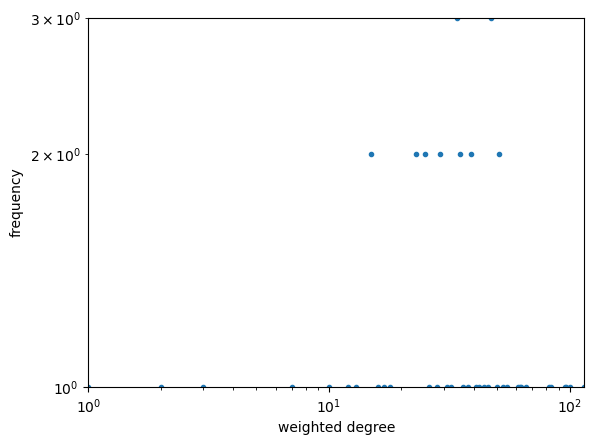

In [72]:
plotDegFrequency(G, weighted='True')

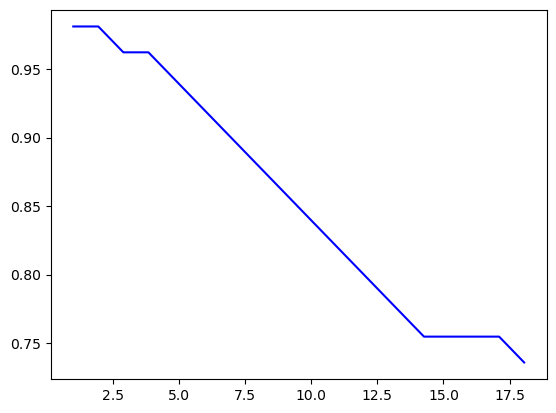

12.057770972772497
13.0
3.6859236575908323
Loglikelihood ratio: 0.31888810786889676
Power law better than exponential
Statistical significance: 0.24441031672802271
Loglikelihood ratio: 5.636515698625999e-10
Power law better than truncated PL
Statistical significance: 0.9999732107583547


Calculating best minimal value for power law fit
C:\Users\and\anaconda3\Lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
Assuming nested distributions


AttributeError: log-logistic

In [98]:
degreeSequence = sorted([d for n, d in G.degree()], reverse = True)
degreeCount = Counter(degreeSequence)
deg, cnt = zip(*degreeCount.items())

maxDeg = max(deg)

values, base = np.histogram(deg, bins = maxDeg)

cumulative = np.cumsum(values)

plt.plot(base[:-1], [float(x) / len(G.nodes()) for x in len(G.nodes()) - cumulative], c = "blue")

plt.show()

results = powerlaw.Fit(degreeSequence)

#print(results.supported_distributions)

print(results.power_law.alpha)
print(results.power_law.xmin)
print(results.power_law.sigma)
R, p = results.distribution_compare("power_law", "exponential")
print(f"Loglikelihood ratio: {R}")
print("Exponential better than power law" if R < 0 else "Power law better than exponential")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare("power_law", "truncated_power_law")
print(f"Loglikelihood ratio: {R}")
print("Truncated PL better than power law" if R < 0 else "Power law better than truncated PL")
print(f"Statistical significance: {p}")
R, p = results.distribution_compare("power_law", "log-logistic")
print(f"Loglikelihood ratio: {R}")
print("Log_logistic better than power law" if R < 0 else "Power law better than Log_logistic")
print(f"Statistical significance: {p}")